# Group Assignment for Numerical Methods in Finance
### By: Lucas Carvalho, Rúben Mendes, and Martim Costa.

Below we list the model parameters as symbolically represented in the paper and their corresponding variable name in our code.

Option Parameters:

$S_0$ = `S0`

$K$ = `K`

$r$ = `r`

$\sigma$ = `sigma`

Discretization parameters:

$N$ = `N`

$M$ = `M`

$x^*$ = `xstar`

$a$ = `a`

$b$ = `b`

Jump and telegraph parameters:

$\sigma_j^+$ = `sigmaJp`

$\sigma_j^-$ = `sigmaJm`

$\mu_j^+$ = `muJp`

$\mu_j^+$ = `muJp`

$\lambda$ = `lbda`

$\zeta^+$ = `zeta_plus`

$\zeta^-$ = `zeta_minus`

In [1]:
import math
import numpy as np
import pandas as pd
from scipy.stats import norm

#Visualization
import seaborn as sns
%matplotlib inline
import matplotlib.pyplot as plt


# Option Params
S0 = 20
K = 20
r = 0.05
sigma = 0.25
T = 1

# Disc Params
N = 180
M = 517
xstar = math.log(4*K)
a = 1
b = -1

# Jump & Telegraph Params
sigmaJp = 0.3
sigmaJm = 0.22
muJp = 0.5
muJm = 0.052
#v = 0.01
lbda = 0.3

# Zetas
zeta_plus = 0.02
zeta_minus = 0.08686

# alpha
def alpha_plus(sign : bool):
    if sign == True:
        return r-1/2*sigma**2-lbda*zeta_minus
    elif sign == False:
        return r-1/2*sigma**2-lbda*zeta_plus

# beta
beta = r + lbda

## Discretization:

The value $\Delta x$ was assigned above to `deltax`, which allows us to define the space discretization
$x_m = -x^* + (m-1)\Delta x$ for $m = 1,...,M$. We choose to do so by thinking of this as a function

\begin{align}
x : \{1, \ldots, M \} &\to \mathbb{R} \\
 m & \mapsto -x^* + (m-1)\Delta x
\end{align}

We do the same for $\tau_m$.
\begin{align}
\tau : \{1, \ldots, N \} &\to \mathbb{R} \\
 n & \mapsto (n-1)\Delta \tau
\end{align}

In [2]:
# Space discretization
deltax = 2*xstar / (M-1)
def discx(m : int):
    return (-1)*xstar + (m-1)*deltax

# Time discretization
deltatau = T / (N -1)
def disctau(n : int):
    return (n-1)*deltatau

From the paper, and using the correction submitted by the professor, we obtain that:

$\gamma_1^\pm = -\frac{\alpha_{\pm}}{2\Delta x} + \frac{\sigma^2}{2\Delta x^2}$    
$\gamma_2 = -\frac{\sigma^2}{2\Delta x^2} - \beta$    
$\gamma_3^\pm = \frac{\alpha_{\pm}}{2\Delta x} + \frac{\sigma^2}{2\Delta x^2}$

There are 5 quantities here: $\gamma_1^+, \gamma_1^-, \gamma_2, \gamma_3^+$ and $\gamma_3^-$. Given that this is frequently the case throughout the paper, we made the design choice of implementing these objects wrapped around a function with a boolean argument which can be interpreted as the corresponding + or - sign. We stick to the convention that a `True` boolean value corresponds to the + sign, and a `False` value corresponds to the - sign. This is done for purposes of code neatness.

In [3]:
# gamma
def gamma_plus_one(sign : bool):
    return -alpha_plus(sign)/(2*deltax) + sigma**2/(2*deltax**2)
def gamma_plus_two():
    return -sigma**2/(deltax**2) - beta
def gamma_plus_three(sign : bool):
    return alpha_plus(sign)/(2*deltax) + sigma**2/(2*deltax**2)

$L_{\Delta}^{\pm} = \begin{bmatrix}
0 & 0 &  &  &  &  \\
\gamma_1^{\pm}& \gamma_2 & \gamma_3^{\pm} &  &  &  \\
& \gamma_1^{\pm}& \gamma_2 & \gamma_3^{\pm} &  &  \\
 & \ddots & \ddots & \ddots &  &  \\
 &  & \ddots  & \ddots  & \ddots  &  \\
 &  &  & \gamma_1^{\pm}& \gamma_2 & \gamma_3^{\pm} \\
 &  &  &  & 0 & 0\\
\end{bmatrix}$

In [4]:
def L_delta(sign: bool):
    zero_row = [0]*M
    L = [zero_row]
    vals = [gamma_plus_one(sign), gamma_plus_two(), gamma_plus_three(sign)]
    for i in range(0, M-2):
        L.append([0]*i + vals + [0]*(M-3-i))
    L.append(zero_row)
    return np.array(L)

### Defining the vector E:
We now define

$E_{\pm}^n = 
\begin{bmatrix}
0\\
\varepsilon_{\pm}(\tau_n,x_2) \\
\vdots \\
\varepsilon_{\pm}(\tau_n,x_{M-1}) \\
0\\
\end{bmatrix}$

where $\varepsilon_\pm (\tau, x) = \exp(x+(\sigma_j^\pm)^2/2) \Phi \Big(\frac{x-x^*+(\sigma_j^\pm)^2}{\sigma_j^\pm} \Big )- K \exp (-r \tau) \Phi \Big (\frac{x-x^*}{\sigma_j^\pm} \Big )$. We use the same boolean-sign convention as before.

In [5]:
def epsilon_plus(sign : bool, x,  tau):
    if sign:
        return np.exp(x+sigmaJp**2/2)*norm.cdf((x-xstar+sigmaJp**2)/sigmaJp)- K*np.exp(-r*tau)*norm.cdf((x-xstar)/sigmaJp)
    else:
        return np.exp(x+sigmaJm**2/2)*norm.cdf((x-xstar+sigmaJm**2)/sigmaJm)- K*np.exp(-r*tau)*norm.cdf((x-xstar)/sigmaJm)

In [6]:
def E_plus(sign : bool,n):
    E=[[float(0)]]
    for i in range(2,M):
        E.append([float(epsilon_plus(sign,disctau(n),discx(i)))])
    E.append([0])
    return np.array(E)

In the paper, two functions, $f^+_{i,j}$ and $f^-_{i,j}$, are introduced and necessary for the definition of $M^\pm$. They are defined below:

In [7]:
#f+-
def f_plus(sign:bool, a,b):
    if sign:
        f_= norm.pdf(b-a, muJp, sigmaJp**2)
    else:
        f_= norm.pdf(b-a, muJm, sigmaJm**2)
    return f_

The matrix $M^{\pm}$ is defined by

$M^{\pm} = \begin{bmatrix}
0 & 0 & \cdots & 0   \\
\omega_1 f_{2,1}^{\mp}& \omega_2 f_{2,2}^{\mp}& \cdots & \omega_M f_{2,M}^{\mp}  \\
\vdots& \vdots& \ddots & \vdots  \\
\omega_{1} f_{M-1,1}^{\mp}& \omega_{2} f_{M-1,2}^{\mp}& \cdots & \omega_M f_{M-1,M}^{\mp}  \\
0 & 0 & \cdots & 0   \\
\end{bmatrix}$

which, like other matrices, we implement as a 2-dimensional `np.array`. Note that the $\pm$ symbol is inverted within the matrix. Our earlier design choice allows us to negate the boolean argument and easily express the same thing. This improves the readability of our code.

In [8]:
def M_plus(sign:bool):
    zero_row = [0]*M
    M_= [zero_row]
    for i in range(2,M):
        row = [deltax/2 * f_plus(not sign, discx(i), discx(j)) for j in range(2, M)]
        row.insert(0, deltax*f_plus(not sign,discx(i), discx(1)))
        row.append(deltax/2*f_plus(not sign,discx(i),discx(M)))
        M_.append(row)
    M_.append(zero_row)
    return np.array(M_)

## Solving the linear systems:
By looking at our system for a fixed $n$, we can see that $M^\pm$ does not depend on $n$, and neither does $L_\Delta^\pm$. 

$(aI-\Delta \tau L_{\Delta}^+)U^{n+1} = -bU^{n}+\Delta \tau \lambda(M^+V^{n}+\lambda E_{+}^{n}) + Bc\\$
$(aI-\Delta \tau L_{\Delta}^-)V^{n+1} = -bV^{n}+\Delta \tau \lambda(M^-U^{n}+\lambda E_{-}^{n}) + Bc$

Initially we were including their computation within the `for` loop that runs in Step 2 of the algorithm, resulting in unnecessarily slow code that was even difficult to debug given the time it took to produce an output. We solved this problem by defining these objects outside the `for` loop.

The vector $E_\pm^{(n)}$ does depend on $n$ but we chose instead to store everything inside an array. We did so because while debugging our program, it was often the case that we wanted to run Step 2 of the algorithm more than once, and it was significantly slower to be computing these vectors repeatedly.

In [9]:
#Memory - Speed Trade-off --- Optimizations

M_p = M_plus(True)
M_n = M_plus(False)

L_delta_p = L_delta(True)
L_delta_n = L_delta(False)

# Since this is computationally intensive, we separate it into this cell and store it in an array for re-use.
E_p = [E_plus(True,n) for n in range(1,N)]
E_n = [E_plus(False,n) for n in range(1,N)]

The values $(aI-\Delta \tau L_{\Delta}^+)U^{n+1}$ and $(aI-\Delta \tau L_{\Delta}^-)V^{n+1}$ can be immediately computed.

In [10]:
lhsU = a*np.eye(M)-deltatau*L_delta_p
lhsV = a*np.eye(M)-deltatau*L_delta_n

Given that `lhsU` and `lhsV` are tridiagonal matrices, we can use the Thomas Algorithm to solve each linear system in $O(M)$ operation per iteration of the `for` loop. We closely follow the implementation found here https://gist.github.com/cbellei/8ab3ab8551b8dfc8b081c518ccd9ada9 with minor changes.

In [11]:
def thomas_solve(A,d):
    a = np.diag(A, k = -1).tolist()
    b = np.diag(A, k = 0).tolist()
    c = np.diag(A, k = 1).tolist()
    
    # Number of equations
    nf = len(d)
    
    # copy arrays
    ac, bc, cc, dc = a, b, c, d
    for it in range(1, nf):
        mc = ac[it-1]/bc[it-1]
        bc[it] = bc[it] - mc*cc[it-1] 
        dc[it] = dc[it] - mc*dc[it-1]
        
    xc = bc
    xc[-1] = dc[-1]/bc[-1]

    for il in range(nf-2, -1, -1):
        xc[il] = (dc[il]-cc[il]*xc[il+1])/bc[il]

    return np.array(xc)

In [12]:
## STEP 1
U = np.array([[max(0,np.exp(discx(m))-K)] for m in range(1,M+1)])
V = U

# STEP 2
for n in range(0,N-1):
    
    # Compute rhsU
    rhsU1 = np.dot(M_p,(V[:,n]).reshape(-1,1))
    rhsU2 = np.add(rhsU1,lbda*(E_p[n]))
    rhsU3 = deltatau*lbda*(rhsU2)
    rhsU4 = np.add(-b*(U[:,n]).reshape(-1,1),rhsU3)
    # Boundary conditions (Bc)
    rhsU4[0,0] = 0
    rhsU4[-1,0] = a*(np.exp(discx(M))-K*np.exp(-r*disctau(n)))
     
    # Ax=b
    U_ = thomas_solve(lhsU, rhsU4)
    U = np.append(U,U_, axis=1)

    rhsV1 = np.dot(M_n,(U[:,n]).reshape(-1,1))
    rhsV2 = np.add(rhsV1,lbda*(E_n[n]))
    rhsV3 = deltatau*lbda*(rhsV2)
    rhsV4 = np.add(-b*(V[:,n]).reshape(-1,1),rhsV3)
    # Boundary conditions (Bc)
    rhsV4[0,0] = 0
    rhsV4[-1,0] = a*(np.exp(discx(M))-K*np.exp(-r*disctau(n)))

    # Ax=b
    V_= thomas_solve(lhsV,rhsV4)
    V = np.append(V,V_, axis=1)

## Black and Scholes

The Black-Scholes model can be implemented using the following equations:

\begin{equation}
	\mathrm C(\mathrm S,\mathrm t)= \mathrm N(\mathrm d_1)\mathrm S - \mathrm N(\mathrm d_2) \mathrm K \mathrm e^{-rt}
	\label{eq:2}
\end{equation}

\begin{equation}
	\mathrm d_1= \frac{1}{\sigma \sqrt{\mathrm t}} \left[\ln{\left(\frac{S}{K}\right)} + t\left(r + \frac{\sigma^2}{2} \right) \right]
\end{equation}

\begin{equation}
	\mathrm d_2= \frac{1}{\sigma \sqrt{\mathrm t}} \left[\ln{\left(\frac{S}{K}\right)} + t\left(r - \frac{\sigma^2}{2} \right) \right]
\end{equation}

Following the original paper we do so for the purpose of comparing with the model under study.

In [13]:
def d1(S_t,K,rate,sigma,maturity_time):
    d = (np.log(S_t/K) + (rate+sigma**2/2)*(maturity_time))/(sigma*np.sqrt(maturity_time))
    return d

def d2(S_t,K,rate,sigma,maturity_time):
    d = d1(S_t,K,rate,sigma,maturity_time) - sigma*np.sqrt(maturity_time)
    return d

def european_call(S_t,K,rate,sigma,maturity_time):
    D1 = d1(S_t,K,rate,sigma,maturity_time)
    D2 = d2(S_t,K,rate,sigma,maturity_time)
    call = S_t*norm.cdf(D1) - K*np.exp(-rate*maturity_time)*norm.cdf(D2)
    return call


## Charts:

### Black-Scholes vs. JTDM

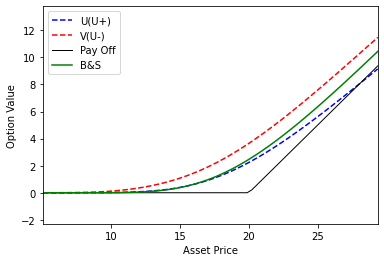

In [14]:
plt.rcParams['axes.xmargin'] = 0
plt.rcParams['axes.ymargin'] = 0.2

#convert vectors into normal lists
U_last_vector = [i for i in U[:,-1].reshape(-1,1)]
V_last_vector = [i for i in V[:,-1].reshape(-1,1)]

#Creating series for chart 
x_plot = [] #Convert log(S) to exp(log(S))
payoff = [] #calculate terminal payoff
BS = [] # list of B&S values
for i in range(0,len(U_last_vector)):
    x_plot.append(np.exp(discx(i)))
    payoff.append(max(np.exp(discx(i))-K,0))
    BS.append(european_call(np.exp(discx(i)),K,r,sigma,T))

# Formula to find the index of closest S value of the chart in the paper
def min_diff_pos(array_like, target):
    return np.abs(np.array(array_like)-target).argmin()

#range of chart in the paper
r1 = min_diff_pos(x_plot, 5)
r2 = min_diff_pos(x_plot, 30)

# Defining range of results
x_plot = x_plot[r1:r2]
payoff_plot = payoff[r1:r2]
U_y = U_last_vector[r1:r2]
V_y = V_last_vector[r1:r2]
BS_y = BS[r1:r2]


# Plot
fig, ax = plt.subplots()
ax.plot(x_plot, U_y, '--b', label='U(U+)')
ax.plot(x_plot, V_y, '--r', label='V(U-)')
ax.plot(x_plot, payoff_plot, '-k', label='Pay Off',linewidth=1)
ax.plot(x_plot, BS_y, '-g', label='B&S')
plt.xlabel('Asset Price')
plt.ylabel('Option Value')

leg = ax.legend();

### Difference between U and V

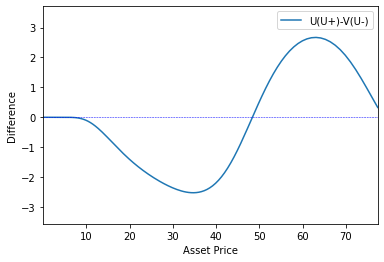

In [15]:
plt.rcParams['axes.xmargin'] = 0
plt.rcParams['axes.ymargin'] = 0.2

#Creating series for chart 
x_plot_2 = [] #Convert log(S) to exp(log(S))
for i in range(0,len(U_last_vector)):
    x_plot_2.append(np.exp(discx(i)))
len(x_plot_2)

diff = [] #Difference between U and V
for u,v in zip(U_last_vector,V_last_vector):
    diff.append(u[0]-v[0])

# Range of chart in the paper
r1 = min_diff_pos(x_plot_2, 0)
r2 = min_diff_pos(x_plot_2, 100)

# Defining range of results
diff = diff[r1:r2]
x_plot_2 = x_plot_2[r1:r2]

# Plot
fig, ax = plt.subplots()
ax.plot(x_plot_2, diff, '-', label='U(U+)-V(U-)')
plt.axhline(y = 0, color = 'b', linestyle = '--',linewidth=0.5)
plt.xlabel('Asset Price')
plt.ylabel('Difference')

leg = ax.legend();